cuda
tensor(1.0000, device='cuda:0')


4096it [00:10, 372.38it/s]

tensor(98.9011)


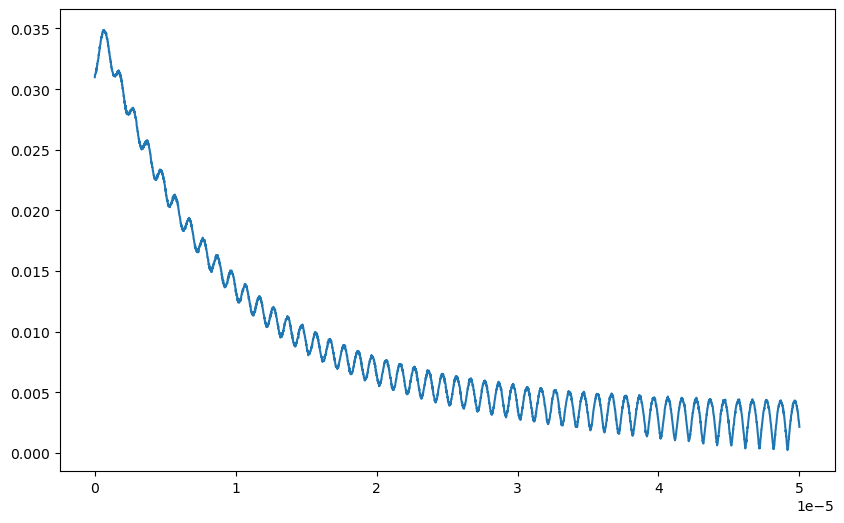

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from deap.tools import Statistics
from pulses import RadarPulseGenerator, CommPulseGenerator, generate_walsh_matrix
import torch
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
t = torch.linspace(0, 1e-4, int(1e5), device=device)
dt = t[1] - t[0]
# Define parameters
T = 1e-4       # Total duration of radar pulse (1e-4 seconds)
B = 1e6        # Bandwidth of radar pulse (1 MHz)
K = 5         # Number of users (OFDMA users)
L = 100        # Number of bits in radar pulse duration
Tb = T / L     # Duration of each bit interval
distance = 100
my_tau = 2*distance / 3e8
snr_db = 30
Ptotal_dbm = 30
snr = 10**(snr_db/10)
Ptotal = 10**((Ptotal_dbm-30)/10)

myCommPulses = CommPulseGenerator(t, Tb, T, device)
myRadarPulses = RadarPulseGenerator(t, T=T, device=device)

radar_pulse1 = myRadarPulses.LFM_pulse(B)
radar_pulse2 = myRadarPulses.Gaussian_pulse(B)

radar_pulse1 = radar_pulse1 / torch.sqrt(torch.sum(torch.abs(radar_pulse1)**2)*dt)
print(torch.sum(torch.abs(radar_pulse1)**2)*dt)
# radar_pulse1 = radar_pulse1/torch.sum(torch.abs(radar_pulse1)**2)/dt
# radar_pulse2 = radar_pulse2/torch.sum(torch.abs(radar_pulse2)**2)/dt

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed


delays = torch.linspace(0, 0.5e-4, 4096)  # Time delays in seconds

xcorr_rx1 = lambda tau : myRadarPulses.cross_correlation(radar_pulse1, torch.roll(radar_pulse1 + np.sqrt(10)*torch.randn(len(radar_pulse1), device=device), shifts=int(my_tau / dt)), tau)
# xcorr_rx2 = lambda tau : myRadarPulses.cross_correlation(radar_pulse2, torch.roll(radar_pulse2, shifts=int(3.5e-6 / dt)), tau)

data1 = torch.zeros_like(delays)
# data2 = torch.zeros_like(delays)
for idx, d in tqdm(enumerate(delays)):
    data1[idx] = xcorr_rx1(d)
    # data2[idx] = xcorr_rx2(d)

print(delays[torch.argmax(data1)]*3e8 / 2)
# print(delays[torch.argmax(data2)])
ax.plot(delays, data1)
# ax.plot(delays, data2)
